In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy.orm.query import Query
from sqlalchemy import create_engine, func, distinct, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Creating the classes for the tables
from pprint import pprint
# pprint(Measurement.__dict__)

# Exploratory Climate Analysis

<IPython.core.display.Javascript object>


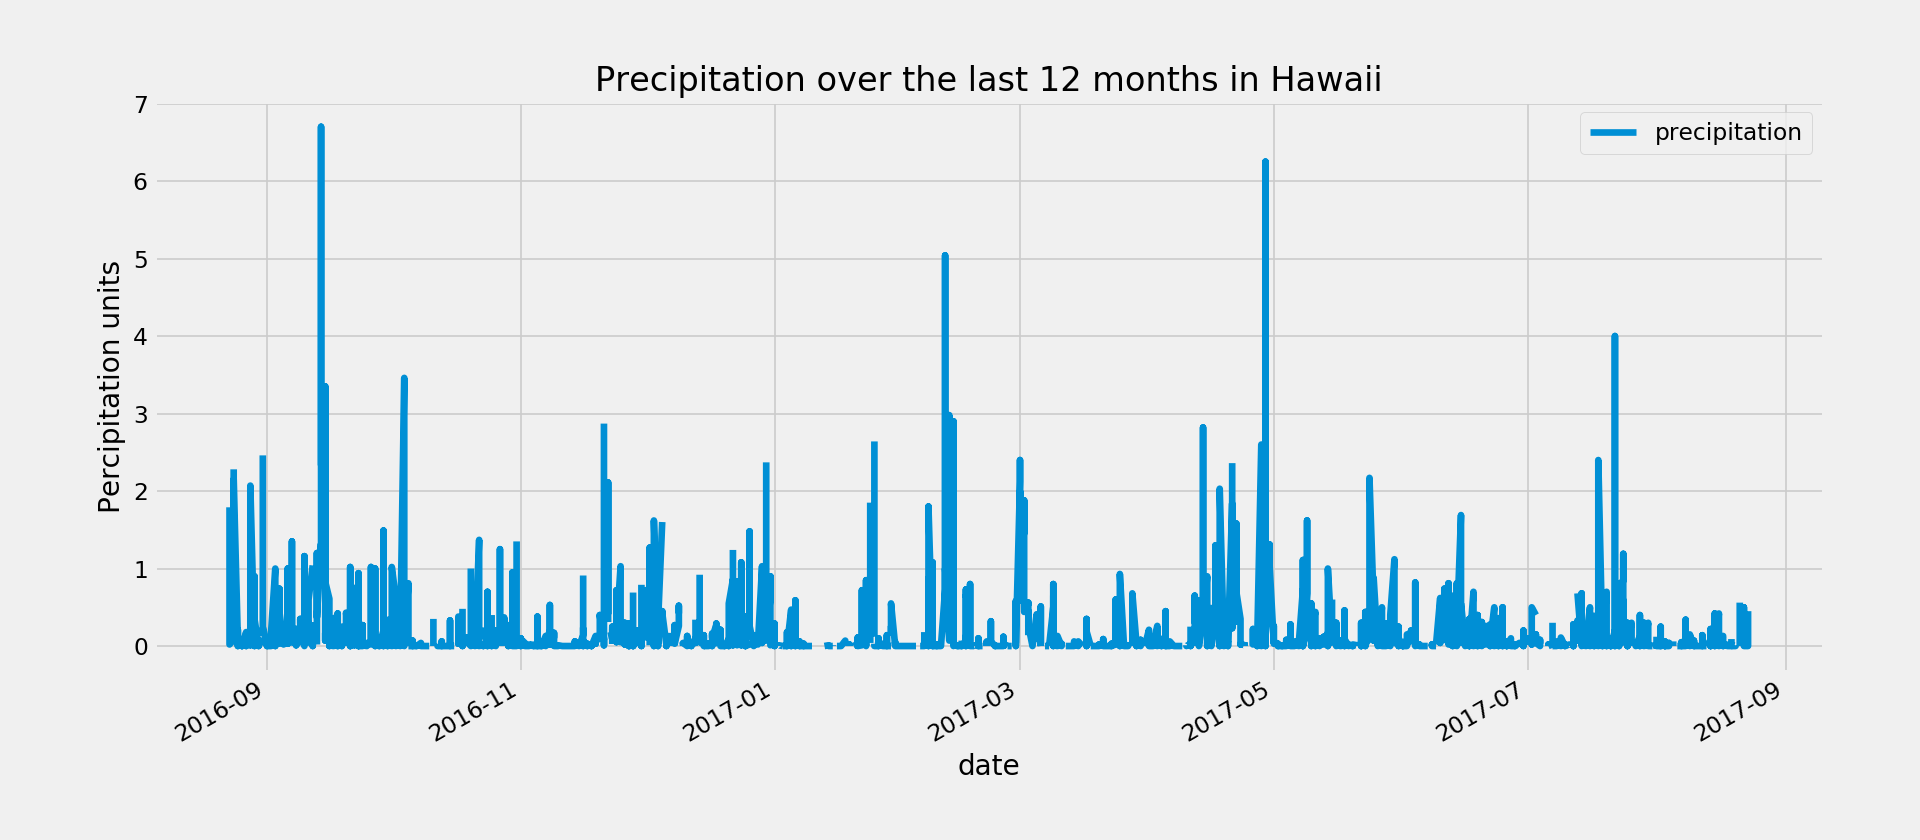

In [27]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# This query involves the measurement of precipitation in inches I believe.  I've made sue this works on sqlite
sql_query_1 = '''
SELECT * FROM measurement m
WHERE m.date BETWEEN '2016-08-23' AND '2017-08-23'
ORDER BY m.date ASC;

-- This is for my own sanity

'''
# Calculate the date 1 year ago from the last data point in the database
# making the query
results_1 = session.query(
    Measurement.id, 
    Measurement.station, 
    Measurement.date, 
    Measurement.prcp, 
    Measurement.tobs)\
.filter(Measurement.date.between('2016-08-23', '2017-08-23'))\
.order_by(Measurement.id.asc()).all()
# results_1 <- This shows the location in the ram

# printing each row of the results
results_last_year = [r for r in results_1]
results_last_year
# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results_1, columns = [
    'id',
    'station',
    'date',
    'precipitation',
    'tobs'])
df.date = pd.to_datetime(df.date)
df
df_date_index = df.set_index('date')

# Sort the dataframe by date
df_date_index_sorted = df_date_index.sort_index()
df_date_index_sorted
# Use Pandas Plotting with Matplotlib to plot the data
fig1, ax1 = plt.subplots()
df_date_index_sorted.precipitation.plot(kind='line', 
                               ax=ax1,
                               figsize = (16,7),
                               grid = True,
                               legend = True,
                               title = 'Precipitation over the last 12 months in Hawaii'
                              )
ax1.set_ylabel('Percipitation units')
fig1.savefig('Precipitation_over_the_last_12_months_in_Hawaii.png')

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_date_index_sorted.precipitation.describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

In [13]:
# Design a query to show how many stations are available in this dataset?
sql_query_2 = '''
-- Again this is for my sanity 
SELECT 
    COUNT(DISTINCT(m.station))
FROM measurement m;
'''
results_2 = session.query(func.count(func.distinct(Measurement.station)))\
.order_by(Measurement.station).all()
results_2

[(9)]

In [14]:
sql_query_2_point_1 = '''
SELECT 
    DISTINCT(m.station)
    ,COUNT(m.station)
    ,MIN(m.tobs) AS min_temp_obs
    ,ROUND(AVG(m.tobs),2) AS avg_temp_obs
    ,MAX(m.tobs) AS max_temp_obs
FROM measurement m
GROUP BY m.station
ORDER BY COUNT(m.station) DESC;
'''

results_2_point_1 = session.query(func.distinct(Measurement.station),
                          func.count(Measurement.station),
                          func.min(Measurement.tobs),
                          func.max(Measurement.tobs),
                          func.round(func.avg(Measurement.tobs),2),
                         )\
.group_by(Measurement.station)\
.order_by(desc(func.count(Measurement.station))).all()

results_2_point_1
# This is where the column names are (look below)
# |Station_Name|Count_of_Stations|min_temp|max_temp|avg_temp|

[('USC00519281', 2772, 54.0, 85.0, 71.66),
 ('USC00519397', 2724, 56.0, 87.0, 74.55),
 ('USC00513117', 2709, 59.0, 85.0, 72.69),
 ('USC00519523', 2669, 56.0, 85.0, 74.54),
 ('USC00516128', 2612, 58.0, 84.0, 70.92),
 ('USC00514830', 2202, 58.0, 85.0, 74.87),
 ('USC00511918', 1979, 53.0, 87.0, 71.62),
 ('USC00517948', 1372, 58.0, 87.0, 74.68),
 ('USC00518838', 511, 58.0, 83.0, 72.72)]

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sql_query_3 = '''
-- Hey look I found my sanity 
SELECT 
    m.station
    ,s.name
    ,COUNT(m.tobs)
FROM measurement m
JOIN station s ON m.station = s.station
GROUP BY m.station 
ORDER BY COUNT(m.tobs) DESC;
'''

results_3 = session.query(
    Measurement.station,
    Station.name,
    func.count(Measurement.tobs))\
.filter(Measurement.station == Station.station)\
.group_by(Measurement.station)\
.order_by(desc(func.count(Measurement.tobs))).all()
pprint(results_3)
results_3[0]

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]


('USC00519281', 'WAIHEE 837.5, HI US', 2772)

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sql_query_4 = '''
SELECT 
    COUNT(m.station)
    ,MIN(m.tobs) AS min_temp_obs
    ,ROUND(AVG(m.tobs),2) AS avg_temp_obs
    ,MAX(m.tobs) AS max_temp_obs
FROM measurement m
WHERE m.station LIKE 'USC00519281';
'''
highest_station = results_3[0][0]
print(f"{highest_station}")

results_4 = \
session.query(
    func.count(Measurement.station),
    func.round(func.avg(Measurement.tobs),2),
    func.min(Measurement.tobs),
    func.max(Measurement.tobs)
)\
.filter(Measurement.station == highest_station).all()
print("[(Count_of_Stations),(avg_tobs),(min_tobs),(max_tobs)]")
pprint(results_4)

USC00519281
[(Count_of_Stations),(avg_tobs),(min_tobs),(max_tobs)]
[(2772, 71.66, 54.0, 85.0)]


<IPython.core.display.Javascript object>


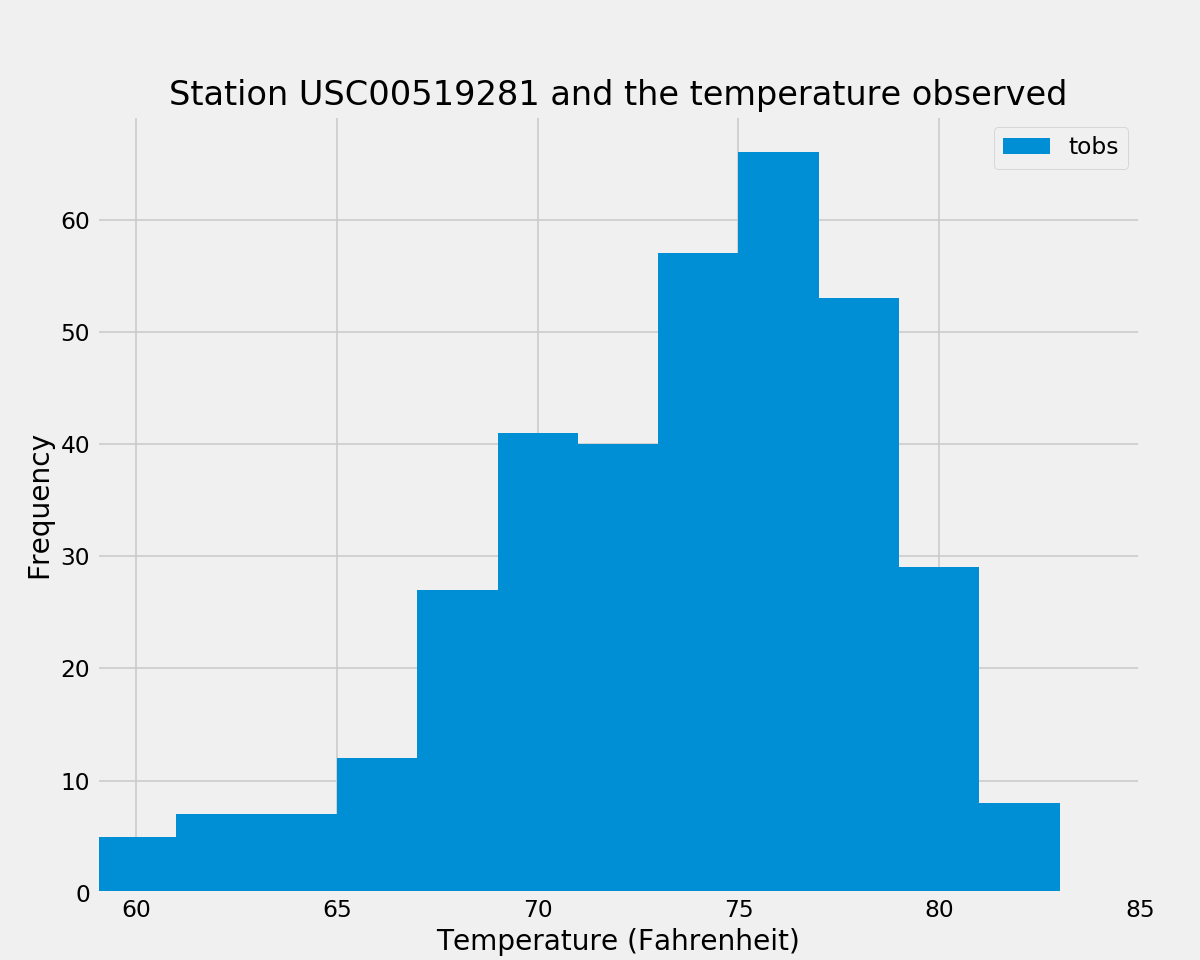

In [26]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sql_query_5 ='''
SELECT 
    m.station
    ,m.tobs
    ,m.date
FROM measurement m
WHERE m.station LIKE 'USC00519281' AND m.date BETWEEN '2016-08-23' AND '2017-08-23';
'''

results_5 = \
session.query(
    Measurement.station,
    Measurement.tobs,
    Measurement.date
)\
.filter(Measurement.station == highest_station)\
.filter(Measurement.date.between('2016-08-23', '2017-08-23')).all()

# pprint(results_5)

temp_obs = [row[1] for row in results_5]
# pprint(temp_obs)
dates = [row[2] for row in results_5]
# pprint(dates)

fig2, ax2 = plt.subplots(figsize = (10,8));
ax2.hist(temp_obs, bins=12, label='tobs');
ax2.set_xlabel('Temperature (Fahrenheit)');
ax2.set_ylabel('Frequency');
ax2.set_title(f'Station {highest_station} and the temperature observed');
ax2.set_xlim(xmin=min(temp_obs),xmax=85);
ax2.legend()
fig2.savefig(f'Station {highest_station} and the temperature observed.png');

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args: 
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """

    return session.query(
        func.min(Measurement.tobs), 
        func.avg(Measurement.tobs), 
        func.max(Measurement.tobs)
    )\
    .filter(Measurement.date >= start_date)\
    .filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


`[(62.0, 69.57142857142857, 74.0)]
`

In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_of_2017 = '2017-01-01'
end_of_2017 = '2017-12-31'
trip_2017 = calc_temps(start_of_2017,end_of_2017)
print(f'''
Tempterature range between the dates {start_of_2017} and {end_of_2017}.
{trip_2017}
''')


Tempterature range between the dates 2017-01-01 and 2017-12-31.
[(58.0, 74.14387974230493, 87.0)]



<IPython.core.display.Javascript object>


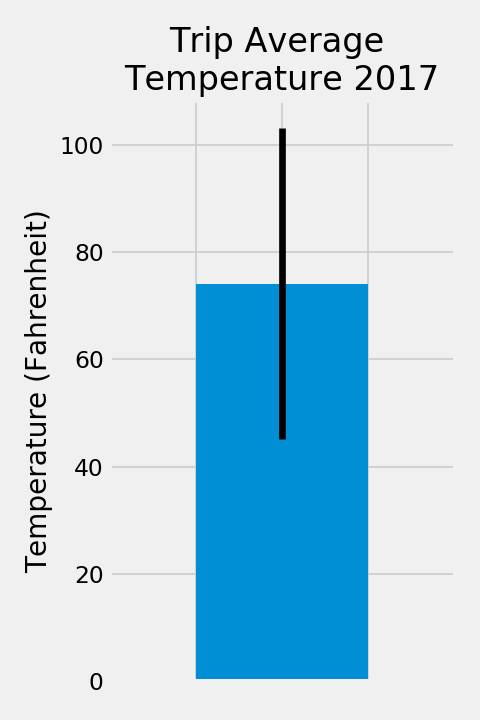

In [29]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig3, ax3 = plt.subplots(figsize=(4,6))

min_2017 = trip_2017[0][0]
avg_2017 = trip_2017[0][1]
max_2017 = trip_2017[0][2]

y_error_2017 = max_2017 - min_2017

ax3.bar(x=0,height=[avg_2017],width=0.1,yerr = y_error_2017);
ax3.set_xlim(xmin= -0.1, xmax=0.1);
ax3.set_xticklabels([]);
ax3.set_ylabel('Temperature (Fahrenheit)');
ax3.set_title('Trip Average \nTemperature 2017');
fig3.tight_layout();
fig3.savefig('Trip Average Temperature 2017.png');

In [38]:
# Calculate the total amount of rainfall per weather station 
# for your trip dates using the previous year's matching dates.

# Sort this in descending order by precipitation amount and list the 
# station, name, latitude, longitude, and elevation
sql_query_6 = '''
-- SQL sanity saturday
SELECT 
    s.station
    ,s.latitude
    ,s.longitude
    ,s.elevation
    ,ROUND(SUM(m.prcp),2) AS sum_prcp
FROM station s
JOIN measurement m ON s.station = m.station
AND m.date BETWEEN '2016-08-23' AND '2017-08-23'
GROUP BY s.station
ORDER BY sum_prcp DESC;
'''

results_6 = \
session.query(
    Station.station,
    Station.latitude,
    Station.longitude,
    Station.elevation,
    func.round(func.sum(Measurement.prcp),2)
)\
.filter(Station.station == Measurement.station)\
.filter(Measurement.date.between('2016-08-23', '2017-08-23'))\
.group_by(Station.station)\
.order_by(desc(func.round(func.sum(Measurement.prcp),2))).all()

results_6

[('USC00516128', 21.3331, -157.8025, 152.4, 147.81),
 ('USC00519281', 21.45167, -157.84888999999998, 32.9, 70.03),
 ('USC00513117', 21.4234, -157.8015, 14.6, 48.51),
 ('USC00519523', 21.33556, -157.71139, 19.5, 38.01),
 ('USC00514830', 21.5213, -157.8374, 7.0, 33.24),
 ('USC00519397', 21.2716, -157.8168, 3.0, 16.09),
 ('USC00517948', 21.3934, -157.9751, 11.9, 4.59)]

## Optional Challenge Assignment

In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [55]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date, end_date = '2017-01-01', '2017-12-31'

# Use the start and end date to create a range of dates
start_date_fixed = dt.datetime.strptime(start_date, '%Y-%m-%d')
end_date_fixed = dt.datetime.strptime(end_date, '%Y-%m-%d')

# Stip off the year and save a list of %m-%d strings
dates_of_trips = []
normals = [] # Like it says up there

while (start_date_fixed <= end_date_fixed):
    dates_of_trips.append(dt.datetime.strftime(start_date_fixed,'%Y-%m-%d'))
    date_stuff = dt.datetime.strftime(start_date_fixed,'%m-%d')
    
    normals.append(list(np.ravel(daily_normals(date_stuff))))
    start_date_fixed += dt.timedelta(days=1)
# Loop through the list of %m-%d strings and calculate the normals for each date
pprint(normals)

[[62.0, 69.15384615384616, 77.0],
 [60.0, 69.39622641509433, 77.0],
 [62.0, 68.9090909090909, 77.0],
 [58.0, 70.0, 76.0],
 [56.0, 67.96428571428571, 76.0],
 [61.0, 68.96491228070175, 76.0],
 [57.0, 68.54385964912281, 76.0],
 [57.0, 67.16071428571429, 75.0],
 [58.0, 67.9298245614035, 78.0],
 [62.0, 69.74137931034483, 77.0],
 [57.0, 67.3103448275862, 78.0],
 [57.0, 67.4074074074074, 81.0],
 [57.0, 67.25454545454545, 77.0],
 [58.0, 69.52631578947368, 77.0],
 [56.0, 69.31372549019608, 78.0],
 [54.0, 68.62962962962963, 80.0],
 [61.0, 69.07407407407408, 76.0],
 [57.0, 68.63157894736842, 77.0],
 [60.0, 68.26315789473684, 78.0],
 [61.0, 68.86666666666666, 78.0],
 [61.0, 70.14545454545454, 76.0],
 [60.0, 69.26415094339623, 76.0],
 [57.0, 69.50909090909092, 79.0],
 [58.0, 68.76271186440678, 78.0],
 [61.0, 67.94915254237289, 75.0],
 [61.0, 70.58620689655173, 77.0],
 [59.0, 68.56896551724138, 75.0],
 [62.0, 69.03703703703704, 77.0],
 [64.0, 69.14, 76.0],
 [60.0, 67.12962962962963, 77.0],
 [60.0, 6

In [57]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df_optional = pd.DataFrame(normals, columns = ['temp_min','temp_max','temp_max'])
df_optional['Date'] = dates_of_trips
df_optional = df_optional.set_index('Date')
df_optional.head()

,temp_min,temp_max,temp_max
Date,,,
2017-01-01,62.0,69.153846,77.0
2017-01-02,60.0,69.396226,77.0
2017-01-03,62.0,68.909091,77.0
2017-01-04,58.0,70.000000,76.0
2017-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


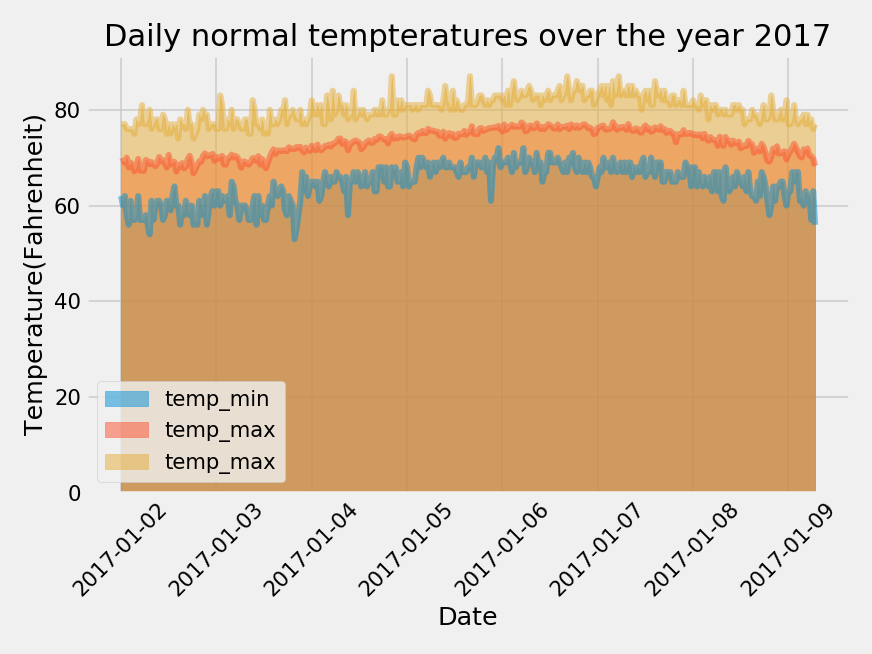

In [76]:
# Plot the daily normals as an area plot with `stacked=False`
fig4, ax4 = plt.subplots(figsize=(8,6))
df_optional.plot.area(ax=ax4, stacked=False);
ax4.set_xticklabels(labels=dates_of_trips, rotation=45);
ax4.set_title('Daily normal tempteratures over the year 2017');
ax4.set_ylabel('Temperature(Fahrenheit)');
fig4.tight_layout();
